In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import roc_auc_score
import pathlib
import joblib
from scipy import stats

In [2]:
path = "/data/mlproject22" if os.path.exists("/data/mlproject22") else "."
train_data = pd.read_csv(os.path.join(path, "transactions.csv.zip"))
print(train_data.shape)
X_train = train_data.drop(columns = "Class")
y_train = train_data["Class"]

class_1_count = np.count_nonzero(y_train == 1)
print("# frauded transactions:", class_1_count)

class_0_count = np.count_nonzero(y_train == 0)
print("# normal transactions:", class_0_count)

(227845, 31)
# frauded transactions: 394
# normal transactions: 227451


In [3]:
from sklearn.preprocessing import StandardScaler

# Step 2: Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Create a new DataFrame with scaled features
df_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Append the target variable back to the scaled DataFrame
df_train_scaled['Class'] = y_train

# Display the scaled DataFrame
#print(df_train_scaled.head())

In [4]:
def remove_outliers(data_set, outlier_class , z_score):
    
    print("removing outliners with class == " , outlier_class);
    
    print("Size before: ", data_set.shape[0])
    print("class" , int(not outlier_class), "samples before: ", (data_set['Class'] == int(not outlier_class)).sum())

    data_set_only_0 = data_set[data_set["Class"] == outlier_class]
    data_set_only_1 = data_set[data_set["Class"] == int(not outlier_class)]

    z_scores = stats.zscore(data_set_only_0.iloc[:, :-1])
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < z_score).all(axis=1)
    data_set_outlier_removed_only_0 = data_set_only_0[filtered_entries]

    df_outlier_removed = pd.concat([data_set_outlier_removed_only_0, data_set_only_1], axis=0)

    print("Size after: ", df_outlier_removed.shape[0])
    print("class" ,int(not outlier_class), "samples after: ", (df_outlier_removed['Class'] ==  int(not outlier_class)).sum())
    print(data_set.shape[0] - df_outlier_removed.shape[0], "outliers removed")
    print("done")

    return df_outlier_removed


In [5]:
df_outlier_removed = remove_outliers(df_train_scaled,0,3)
df_outlier_removed = remove_outliers(df_outlier_removed,1,3)

removing outliners with class ==  0
Size before:  227845
class 1 samples before:  394
Size after:  195452
class 1 samples after:  394
32393 outliers removed
done
removing outliners with class ==  1
Size before:  195452
class 0 samples before:  195058
Size after:  195412
class 0 samples after:  195058
40 outliers removed
done


In [6]:
X_train = df_outlier_removed.drop(columns = "Class")
y_train = df_outlier_removed["Class"]

In [9]:
# 4 : Feature selection

#choosing best features

from sklearn.ensemble import RandomForestClassifier
import pandas as pd

random_state=42

# Create a random forest classifier
rf = RandomForestClassifier()#class_weight={0: 0.2, 1: 0.8})

# Fit the classifier on the data
rf.fit(X_train, y_train)

# Get the feature importances
feature_importances = rf.feature_importances_

# Print feature importance scores
for i, feature in enumerate(X_train.columns):
    print(f"{feature}: {feature_importances[i]}")

# Get the indice of top feature
top_indice = feature_importances.argsort()[-1:]
# Get the names of the top feature
top_feature = X_train.columns[top_indice]
# Print the feature names
print(top_feature)

Time: 0.002917970917369483
Feature0: 0.010007272094144346
Feature1: 0.005975419613678732
Feature2: 0.04740941097731151
Feature3: 0.03134666154390041
Feature4: 0.007371883307895776
Feature5: 0.005400655759044141
Feature6: 0.025759645199792375
Feature7: 0.007068209593695225
Feature8: 0.01006769016707549
Feature9: 0.09462181293926329
Feature10: 0.05660045618558309
Feature11: 0.19312451156615312
Feature12: 0.005181542361579083
Feature13: 0.22036945798158356
Feature14: 0.005273582605815503
Feature15: 0.07156319999645726
Feature16: 0.1194127245625817
Feature17: 0.02552940050375568
Feature18: 0.010426929007951644
Feature19: 0.005200054325711359
Feature20: 0.006554817840250751
Feature21: 0.0038784562327363508
Feature22: 0.0034759572751025753
Feature23: 0.00331783154716939
Feature24: 0.004253551560216326
Feature25: 0.0033509339798058536
Feature26: 0.007005994065185816
Feature27: 0.00310271269594592
Amount: 0.004431253593243974
Index(['Feature13'], dtype='object')


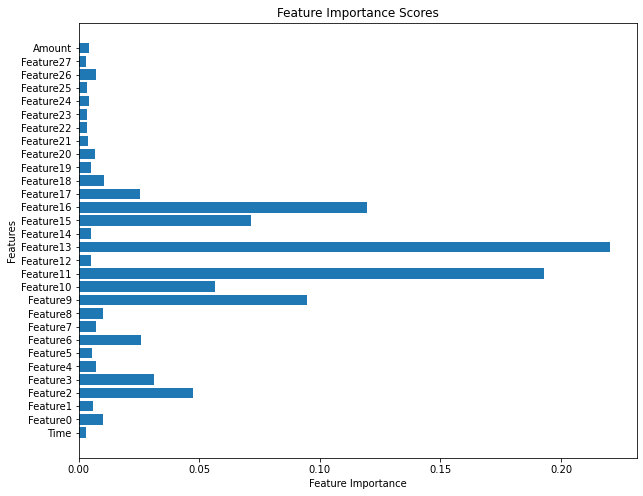

In [11]:
import matplotlib.pyplot as plt

# Create a figure and axis with a larger size
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the size as needed

# Plot the feature importance scores
ax.barh(X_train.columns, feature_importances)

# Set the axis labels and title
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Features')
ax.set_title('Feature Importance Scores')

# Show the plot
plt.show()

In [12]:
X_train_selected_features = X_train[top_feature]

In [13]:
from sklearn.model_selection import train_test_split

# Split into train and test sets
random_seed = 100 # Use an integer to have repeatable results
X_train_my, X_test_my, y_train_my, y_test_my = train_test_split(X_train_selected_features, y_train, test_size=0.3, random_state=random_seed)

Number of samples with Class 1: 117
Number of samples with Class 0: 58507
Accuracy: 0.9997100163755459
Confusion Matrix:
[[58507     0]
 [   17   100]]
Precision: 1.0
Recall: 0.8547008547008547
F1-Score: 0.9216589861751151


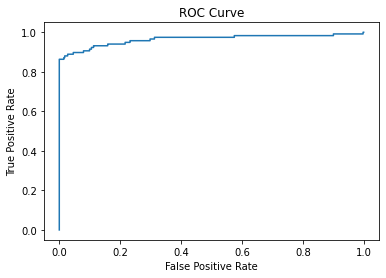

AUC-ROC: 0.9641381212475268


In [14]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# create classifier
clf = GaussianNB()
# Assign the class weights to the classifier
# fit it to training data
clf.fit(X_train_my,y_train_my)
# predict using test data
y_pred = clf.predict(X_test_my)
# Compute predicted probabilities: y_pred_prob
y_pred_prob = clf.predict_proba(X_test_my)

class_1_count = np.count_nonzero(y_test_my == 1)
print("Number of samples with Class 1:", class_1_count)

class_0_count = np.count_nonzero(y_test_my == 0)
print("Number of samples with Class 0:", class_0_count)

accuracy = accuracy_score(y_test_my, y_pred)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_test_my, y_pred)
print("Confusion Matrix:")
print(cm)

precision = precision_score(y_test_my, y_pred)
print("Precision:", precision)

recall = recall_score(y_test_my, y_pred)
print("Recall:", recall)

f1 = f1_score(y_test_my, y_pred)
print("F1-Score:", f1)

fpr, tpr, thresholds = roc_curve(y_test_my, y_pred_prob[:, 1]) # assuming binary classification
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

auc = roc_auc_score(y_test_my, y_pred_prob[:, 1]) # assuming binary classification
print("AUC-ROC:", auc)

In [15]:
model = (clf, top_feature)
joblib.dump(model, "model.joblib")

['model.joblib']